In [3]:
df_loaded.head()

,nome_munic,datahora,casos_novos
0,Adamantina,2020-02-25,0
1,Adolfo,2020-02-25,0
2,Aguaí,2020-02-25,0
3,Águas da Prata,2020-02-25,0
4,Águas de Lindóia,2020-02-25,0


In [4]:
df_filtered = df_loaded[df_loaded.nome_munic=='Indaiatuba']
df_cases = df_filtered[:]['casos_novos'].values.astype('float32')
df_cases

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,   3.,   0.,   0.,
         0.,   0.,   0.,   4.,   1.,   0.,   0.,   2.,   6.,   2.,   1.,
         3.,   0.,   0.,   0.,   2.,   3.,   2.,   0.,   1.,   0.,   0.,
         3.,   3.,   1.,   1.,  13.,   0.,   1.,   6.,   1.,  14.,  15.,
         3.,   3.,   0.,   2.,   1.,  14.,  10.,   1.,   2.,  16.,   5.,
         4.,   3.,   7.,  14.,   3.,   0.,   3.,   3.,   4.,   1.,   4.,
         2.,   2.,   5.,   0.,   3.,  78.,  30.,   1.,   0.,  49.,  30.,
        36.,  52.,  40.,   9.,   1.,  53.,  39.,  59.,  57.,   0.,   4.,
         5.,  20.,  21.,  12.,  10.,  12.,   2.,   4.,  18.,  16.,  32.,
        22.,   3.,   2.,   5.,  18.,  20.,  14.,  5

In [5]:
df_filtered[:][-5:]

,nome_munic,datahora,casos_novos
338860,Indaiatuba,2021-08-03,76
339505,Indaiatuba,2021-08-04,76
340150,Indaiatuba,2021-08-05,112
340795,Indaiatuba,2021-08-06,84
341440,Indaiatuba,2021-08-07,118


In [332]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import pandas as pd

url_repo = 'https://raw.githubusercontent.com/seade-R/dados-covid-sp/master/data/dados_covid_sp.csv'
#url_repo = 'dados_covid_sp.csv'
df_loaded = pd.read_csv(url_repo, delimiter=';', usecols=['nome_munic','casos_novos','datahora'])
data = {'city':'Indaiatuba'}
df_filtered = df_loaded[df_loaded.nome_munic==data['city']]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
df_cases = df_filtered[:]['casos_novos'].values.astype('float32')
df_cases = df_cases.reshape(len(df_cases),1)

scaler = MinMaxScaler(feature_range=(0, 1))
df_cases = scaler.fit_transform(df_cases)


In [501]:
train_size = int(len(df_cases) * 0.8)
test_size = len(df_cases) - train_size
train, test = df_cases[0:train_size, :], df_cases[train_size:len(df_cases)+1, :]
print(len(train), len(test))

472 118


In [502]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [503]:
from tensorflow.keras.optimizers import SGD

hidden_nodes = int(2/3 * look_back)
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dropout(0.055))
# model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dense(256))
#model.add(Dense(1, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])

history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=60, batch_size=2, verbose=1)

Epoch 1/60
155/155 [==============================] - 1s 4ms/step - loss: 0.0450 - mse: 0.0062 - val_loss: 0.0464 - val_mse: 0.0045
Epoch 2/60
155/155 [==============================] - 0s 1ms/step - loss: 0.0477 - mse: 0.0075 - val_loss: 0.0456 - val_mse: 0.0053
Epoch 3/60
155/155 [==============================] - 0s 1ms/step - loss: 0.0512 - mse: 0.0103 - val_loss: 0.0425 - val_mse: 0.0043
Epoch 4/60
155/155 [==============================] - 0s 2ms/step - loss: 0.0431 - mse: 0.0054 - val_loss: 0.0429 - val_mse: 0.0046
Epoch 5/60
155/155 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0055 - val_loss: 0.0416 - val_mse: 0.0042
Epoch 6/60
155/155 [==============================] - 0s 1ms/step - loss: 0.0396 - mse: 0.0059 - val_loss: 0.0409 - val_mse: 0.0041
Epoch 7/60
155/155 [==============================] - 0s 1ms/step - loss: 0.0421 - mse: 0.0049 - val_loss: 0.0414 - val_mse: 0.0043
Epoch 8/60
155/155 [==============================] - 0s 2ms/step - loss: 0.

In [504]:
# evaluate the model
#trainY = scaler.inverse_transform(trainY)
#testY = scaler.inverse_transform(testY)
_, train_mse = model.evaluate(trainX, trainY, verbose=0)
_, test_mse = model.evaluate(testX, testY, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.006, Test: 0.004


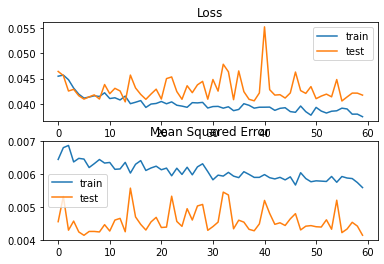

In [505]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot mse during training
plt.subplot(212)
plt.title('Mean Squared Error')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

In [506]:
score = model.summary()
print(score)

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 128)               69632     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 257       
Total params: 102,913
Trainable params: 102,913
Non-trainable params: 0
_________________________________________________________________
None


In [507]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [508]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))


Train Score: 49.48 RMSE
Train Score: 25.72 MAE
Test Score: 42.52 RMSE
Test Score: 27.58 MAE


In [509]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [510]:
train_mda = mda(trainY[0], trainPredict[:,0])
test_mda = mda(testY[0], testPredict[:,0])
print('Train Score: %2.2f %% of MDA' % (train_mda*100))
print('Test Score: %2.2f %% of MDA' % (test_mda*100))


Train Score: 53.23 % of MDA
Test Score: 38.18 % of MDA


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
lstm_9 (LSTM)                (None, 1, 128)            69632     
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
=================================================================
Total params: 217,857
Trainable params: 217,857
Non-trainable params: 0
_________________________________________________________________
None


Train Score: 48.14 RMSE
Train Score: 24.43 MAE
Test Score: 50.52 RMSE
Test Score: 37.64 MAE

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_cases)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [15]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_cases)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict)-1:-1, :] = testPredict

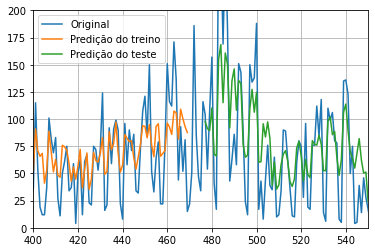

In [11]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_cases), label='Original')
plt.plot(trainPredictPlot , label='Predição do treino')
plt.plot(testPredictPlot, label='Predição do teste')
#plt.plot(scaler.inverse_transform([trainY]), label='?')
plt.grid()
plt.xlim(400, 550)
plt.ylim(0, 200)
plt.legend()
plt.show()

<a href='https://www.linkedin.com/pulse/rmse-ou-mae-como-avaliar-meu-modelo-de-machine-learning-rezende/?originalSubdomain=pt'>rmse vs mae</a>

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
lstm_14 (LSTM)               (None, 4)                 192       
_________________________________________________________________
dropout_7 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_8 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_9 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
=================================================================
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________
None

Train Score: 48.76 RMSE

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
lstm (LSTM)                  (None, 4)                 128       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
=================================================================
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
None

Train Score: 52.45 RMSE - Root Mean Squared Error

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
=================================================================
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
None

Train Score: 52.48 RMSE

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
lstm_1 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
=================================================================
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None

Train Score: 52.59 RMSE

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
lstm_2 (LSTM)                (None, 7)                 308       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
=================================================================
Total params: 316
Trainable params: 316
Non-trainable params: 0
_________________________________________________________________
None

Train Score: 52.65 RMSE

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
lstm_1 (LSTM)                (None, 4)                 192       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
=================================================================
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
None

Train Score: 50.81 RMSE

In [66]:
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
x = model.predict(df_cases[-7:].reshape(1, 1, 7))
testPredict = scaler.inverse_transform(x)
testPredict

array([[90.316154]], dtype=float32)

In [86]:
cases = df_cases[-7:]
new=np.append(cases,testPredict,axis=0)
cases

array([[0.1149773 ],
       [0.16944024],
       [0.12708017],
       [0.17851739],
       [0.02118003],
       [0.00907716],
       [0.16641451]], dtype=float32)

In [83]:
new

array([[1.1497730e-01],
       [1.6944024e-01],
       [1.2708017e-01],
       [1.7851739e-01],
       [2.1180030e-02],
       [9.0771560e-03],
       [1.6641451e-01],
       [9.0316154e+01]], dtype=float32)

In [85]:
np.delete(new, 0, axis=0)

array([[1.6944024e-01],
       [1.2708017e-01],
       [1.7851739e-01],
       [2.1180030e-02],
       [9.0771560e-03],
       [1.6641451e-01],
       [9.0316154e+01]], dtype=float32)

In [11]:
cases = df_cases[-7:]
for _ in range(7):
    pred_day = model.predict(cases.reshape(1, 1, 7))
    cases = np.append(cases,pred_day,axis=0)
    cases = np.delete(cases, 0, axis=0)
eissoae = np.append(df_cases[-7:],cases,axis=0)

In [128]:
eissoae

array([[0.1149773 ],
       [0.16944024],
       [0.12708017],
       [0.17851739],
       [0.02118003],
       [0.00907716],
       [0.16641451],
       [0.13663563],
       [0.1290283 ],
       [0.113158  ],
       [0.11562242],
       [0.06924921],
       [0.06873225],
       [0.10365728]], dtype=float32)

In [132]:
predis = scaler.inverse_transform(eissoae[-7:])
predis = np.round(predis).astype(int)

In [133]:
predis

array([[90],
       [85],
       [75],
       [76],
       [46],
       [45],
       [69]])

In [136]:
for e in predis:
    print(int(e))

90
85
75
76
46
45
69


In [12]:
x = df_filtered[-len(cases):]['datahora']

In [15]:
scaler.inverse_transform(df_cases[-7:])

array([[ 76.       ],
       [112.       ],
       [ 84.       ],
       [118.       ],
       [ 14.       ],
       [  6.0000005],
       [110.       ]], dtype=float32)

In [13]:
x

339505    2021-08-04
340150    2021-08-05
340795    2021-08-06
341440    2021-08-07
342085    2021-08-08
342730    2021-08-09
343375    2021-08-10
Name: datahora, dtype: object

In [105]:
from datetime import datetime, timedelta

In [124]:
y = datetime.now()
y

datetime.datetime(2021, 8, 10, 20, 58, 14, 191347)

In [120]:
y = y.strftime("%Y-%m-%d")

In [121]:
x

array(['2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
       '2021-08-08', '2021-08-09', '2021-08-10'], dtype=object)

In [122]:
if y in x:
    print(1)

1


In [126]:
y += timedelta(days=1)

In [127]:
y

datetime.datetime(2021, 8, 11, 20, 58, 14, 191347)